# Tutorial 2: Cosserat Rod

### Import necessary modules

In [4]:
import numpy as np

# Import Wrappers
from elastica.wrappers import BaseSystemCollection, Constraints, Forcing

# Import Cosserat Rod Class
from elastica.rod.cosserat_rod import CosseratRod

# Import Boundary Condition Classes
from elastica.boundary_conditions import OneEndFixedRod, FreeRod
from elastica.external_forces import EndpointForces

# Import Timestepping Functions
from elastica.timestepper.symplectic_steppers import PositionVerlet
from elastica.timestepper import integrate

### Create the Simulation

In [5]:
class TimoshenkoBeamSimulator(BaseSystemCollection, Constraints, Forcing):
    pass

timoshenko_sim = TimoshenkoBeamSimulator()

### Define parameters for each rod

In [6]:
# setting up test params
n_elem = 100     # number of elements

start = np.zeros((3,))                  # Starting position of first node in rod
direction = np.array([0.0, 0.0, 1.0])   # Direction the rod extends
normal = np.array([0.0, 1.0, 0.0])      # normal vector of rod


base_length = 3.0     ####              # original length of rod (m)
base_radius = 0.25    ####              # original radius of rod (m)
base_area = np.pi * base_radius ** 2   ###

density = 1000  # density of rod (kg/m^3)
# For shear modulus of 1e4, nu is 99!
nu = 0.1  ####  # Energy dissipation of rod
E = 1e6   ####  # Elastic Modulus (Pa)  
poisson_ratio = 0.5  ###             # Poisson Ratio

shear_modulus = E / (poisson_ratio + 1.0)  



### Include rod

In [7]:
shearable_rod = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    nu,
    E,
    shear_modulus=shear_modulus,
)

timoshenko_sim.append(shearable_rod)

### Define boundary conditions

In [8]:
timoshenko_sim.constrain(shearable_rod).using(
    OneEndFixedRod,                           # Displacement BC being applied
    constrained_position_idx=(0,),            # Node number to apply BC
    constrained_director_idx=(0,)             # Element number to apply BC
)
print("One end of the rod is now fixed in place")

One end of the rod is now fixed in place


### Define applied forces

In [9]:
   #Define 1x3 array of the applied forces
origin_force = np.array([0.0, 0.0, 0.0])
end_force = np.array([-20.0, 0.0, 0.0])
ramp_up_time = 5.0

timoshenko_sim.add_forcing_to(shearable_rod).using(
    EndpointForces,             # Traction BC being applied
    origin_force,               # Force vector applied at first node
    end_force,                  # Force vector applied at last node
    ramp_up_time=ramp_up_time   # Ramp up time 
)
print("Forces added to the rod")

Forces added to the rod


### Finalize system, define time stepper and run simulation

In [10]:
timoshenko_sim.finalize()
print("System finalized")

System finalized


In [11]:
final_time = 10.0                      # seconds
dl = base_length / n_elem              
dt = 0.01 * dl                         # seconds
total_steps = int(final_time / dt)
print("Total steps to take", total_steps)

timestepper = PositionVerlet()

Total steps to take 33333


In [12]:
integrate(timestepper, timoshenko_sim, final_time, total_steps)

100%|██████████| 33333/33333 [00:08<00:00, 3935.83it/s] 

Final time of simulation is :  10.00000000000566


10.00000000000566

## Post Processing Results

### Create Mathematical Model Calculator

In [13]:
# Compute beam position for sherable and unsherable beams.
def analytical_result(arg_rod, arg_end_force, shearing=True, n_elem=500):
    base_length = np.sum(arg_rod.rest_lengths)
    arg_s = np.linspace(0.0, base_length, n_elem)
    if type(arg_end_force) is np.ndarray:
        acting_force = arg_end_force[np.nonzero(arg_end_force)]
    else:
        acting_force = arg_end_force
    acting_force = np.abs(acting_force)
    linear_prefactor = -acting_force / arg_rod.shear_matrix[0, 0, 0]
    quadratic_prefactor = (
        -acting_force
        / 2.0
        * np.sum(arg_rod.rest_lengths / arg_rod.bend_matrix[0, 0, 0])
    )
    cubic_prefactor = (acting_force / 6.0) / arg_rod.bend_matrix[0, 0, 0]
    if shearing:
        return (
            arg_s,
            arg_s * linear_prefactor
            + arg_s ** 2 * quadratic_prefactor
            + arg_s ** 3 * cubic_prefactor,
        )
    else:
        return arg_s, arg_s ** 2 * quadratic_prefactor + arg_s ** 3 * cubic_prefactor

### Create Plot Results Function

In [14]:
def plot_timoshenko(shearable_rod, end_force):
    import matplotlib.pyplot as plt
    analytical_shearable_positon = analytical_result(
        shearable_rod, end_force, shearing=True
    )
    fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    ax = fig.add_subplot(111)
    ax.grid(b=True, which="major", color="grey", linestyle="-", linewidth=0.25)
    ax.plot(
        analytical_shearable_positon[0],
        analytical_shearable_positon[1],
        "k--",
        label="Timoshenko",
    )
    ax.plot(
        shearable_rod.position_collection[2, :],
        shearable_rod.position_collection[0, :],
        "b-",
        label="Crosserat rod n=" + str(shearable_rod.n_elems),
    )
    ax.legend(prop={"size": 12})
    ax.set_ylabel("Y Position (m)", fontsize=12)
    ax.set_xlabel("X Position (m)", fontsize=12)
    plt.show()

### Plot Results

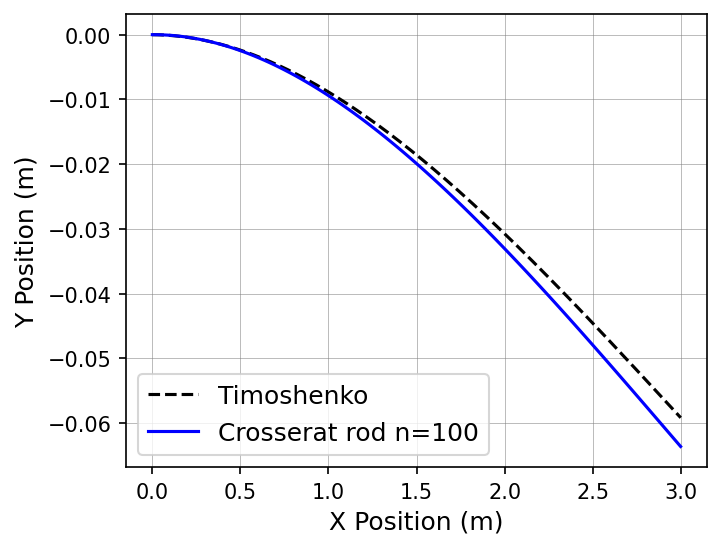

In [15]:
plot_timoshenko(shearable_rod, end_force)

## Task 1

Simulate a unsherable rod modifiying the following parameters in the sample rod: 

Density =1000 Kg/m^3, energy dissipation of rod =99 meV,Elastic Modulus =1x10^6 Pa, poisson_ratio = -0.85.   
    

## Task 2

1) Modify the dimensions of the sherable rod with the following parameters:

Base_length = 9.0 m, base_radius = 0.25 m.

1) Modify the dimensions of the unsherable rod with the following parameters:

Base_length = 9.0 m, base_radius = 0.25 m.

## Task 3

Simulate a sherable rod modifiying the Elastic modulus (young's modulus of elasticity) for the following silicon rubber:

1. Ecoflex 00-30        E= 0.1694 MPa
2. Ecoflex 00-50        E= 0.2642 MPa
3. Dragon Skin F/X PRO  E=0.5604 MPa

Source: Table 3.2: Derived Youn's modulus of elasticity for silicone rubbers.
https://spectrum.library.concordia.ca/id/eprint/973889/1/Atieh_MASc_S2012.pdf




# Dynamic Simulation

In [16]:
import numpy as np

# Import Wrappers
from elastica.wrappers import BaseSystemCollection, Constraints, Forcing

# Import Cosserat Rod Class
from elastica.rod.cosserat_rod import CosseratRod

# Import Boundary Condition Classes
from elastica.boundary_conditions import OneEndFixedRod, FreeRod
from elastica.external_forces import EndpointForces

# Import Timestepping Functions
from elastica.timestepper.symplectic_steppers import PositionVerlet
from elastica.timestepper import integrate

In [17]:
# setting up test params
n_elem = 100

density = 1000
nu = 0.1  ####
E = 1e6   ####
# For shear modulus of 1e4, nu is 99!
poisson_ratio = 99  ### 
shear_modulus = E / (poisson_ratio + 1.0)  

start = np.zeros((3,))
direction = np.array([0.0, 0.0, 1.0])
normal = np.array([0.0, 1.0, 0.0])
base_length = 3.0     ####
base_radius = 0.25    ####
base_area = np.pi * base_radius ** 2   ###

In [18]:
origin_force = np.array([0.0, 20.0, 0.0])
end_force = np.array([-20.0, 0.0, 0.0])
ramp_up_time = 5.0

In [19]:
final_time = 12.0
dl = base_length / n_elem
dt = 0.01 * dl
total_steps = int(final_time / dt)
print("Total steps to take", total_steps)

Total steps to take 40000


In [20]:
time = 0.0
class BeamSimulator(BaseSystemCollection, Constraints, Forcing):
    pass


dynamic_update_sim = BeamSimulator()

shearable_rod_new = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    nu,
    E,
    poisson_ratio,
)
dynamic_update_sim.append(shearable_rod_new)
dynamic_update_sim.constrain(shearable_rod_new).using(
    OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
)
dynamic_update_sim.add_forcing_to(shearable_rod_new).using(
    EndpointForces, origin_force, end_force, ramp_up_time=ramp_up_time
)



dynamic_update_sim.finalize()

C:\Users\Nicoline L. Thomsen\AppData\Local\Programs\Python\Python39\lib\site-packages\elastica\rod\factory_function.py:473: UserWarning: Shear modulus cannot be found in kwargs. Poisson ratio 0.5 is used to compute shear modulus 666666.6666666666, using the equation: shear_modulus = youngs_modulus / (poisson_ratio + 1.0).
  warnings.warn(message, category=UserWarning)


In [21]:
# Compute beam position for sherable and unsherable beams.
def analytical_result(arg_rod, arg_end_force, shearing=True, n_elem=100):
    base_length = np.sum(arg_rod.rest_lengths)
    arg_s = np.linspace(0.0, base_length, n_elem)
    if type(arg_end_force) is np.ndarray:
        acting_force = arg_end_force[np.nonzero(arg_end_force)]
    else:
        acting_force = arg_end_force
    acting_force = np.abs(acting_force)
    linear_prefactor = -acting_force / arg_rod.shear_matrix[0, 0, 0]
    quadratic_prefactor = (
        -acting_force
        / 2.0
        * np.sum(arg_rod.rest_lengths / arg_rod.bend_matrix[0, 0, 0])
    )
    cubic_prefactor = (acting_force / 6.0) / arg_rod.bend_matrix[0, 0, 0]
    if shearing:
        return (
            arg_s,
            arg_s * linear_prefactor
            + arg_s ** 2 * quadratic_prefactor
            + arg_s ** 3 * cubic_prefactor,
        )
    else:
        return arg_s, arg_s ** 2 * quadratic_prefactor + arg_s ** 3 * cubic_prefactor

In [22]:
def run_and_update_plot(simulator, dt, start_time, stop_time, ax,ax2,ax3):
    from elastica.timestepper import extend_stepper_interface
    from elastica.timestepper.symplectic_steppers import PositionVerlet

    timestepper = PositionVerlet()
    do_step, stages_and_updates = extend_stepper_interface(timestepper, simulator)

    n_steps = int((stop_time - start_time) / dt)
    time = start_time
    for i in range(n_steps):
        time = do_step(timestepper, stages_and_updates, simulator, time, dt)
    plot_timoshenko_dynamic(shearable_rod_new, end_force, time, ax)
    return time


def plot_timoshenko_dynamic(shearable_rod, end_force, time, ax):
    import matplotlib.pyplot as plt
    from IPython import display

    analytical_shearable_positon = analytical_result(
        shearable_rod, end_force, shearing=True
    )

    ax.clear()
    ax.grid(b=True, which="major", color="grey", linestyle="-", linewidth=0.25)
    ax.plot(
        analytical_shearable_positon[0],
        analytical_shearable_positon[1],
        "k--",
        label="Timoshenko",
    )

    ax.plot(
        shearable_rod.position_collection[2, :],
        shearable_rod.position_collection[0, :],
        "b-",
        label="shearable rod",
    )


    ax.legend(prop={"size": 12}, loc="lower left")
    ax.set_ylabel("Y Position (m)", fontsize=12)
    ax.set_xlabel("X Position (m)", fontsize=12)
    ax.set_title("Simulation Time: %0.2f seconds" % time)
    ax.set_xlim([-0.1, 3.1])
    ax.set_ylim([-0.09, 0.002])

    
    ax2.clear()
    ax2.grid(b=True, which="major", color="grey", linestyle="-", linewidth=0.25)
    ax2.plot(
        analytical_shearable_positon[0],
        "k--",
        label="Timoshenko",
    )
    ax2.plot(
        shearable_rod.position_collection[2, :],
        "b-",
        label="shearable rod",
    )
    ax2.legend(prop={"size": 10}, loc="lower left")
    ax2.set_ylabel("X Position (m)", fontsize=12)
    ax2.set_xlabel("n samples", fontsize=12)
    ax2.set_xlim([-0, 100])

    ax3.clear()
    ax3.grid(b=True, which="major", color="grey", linestyle="-", linewidth=0.25)
    ax3.plot(
        analytical_shearable_positon[1],
        "k--",
        label="Timoshenko",
    )
    ax3.plot(
        shearable_rod.position_collection[0, :],
        "b-",
        label="shearable rod",
    )
    ax3.legend(prop={"size": 10}, loc="lower right")
    ax3.set_ylabel("Y Position (m)", fontsize=12)
    ax3.set_xlabel("n samples", fontsize=12)
    ax3.set_xlim([0, 100])  

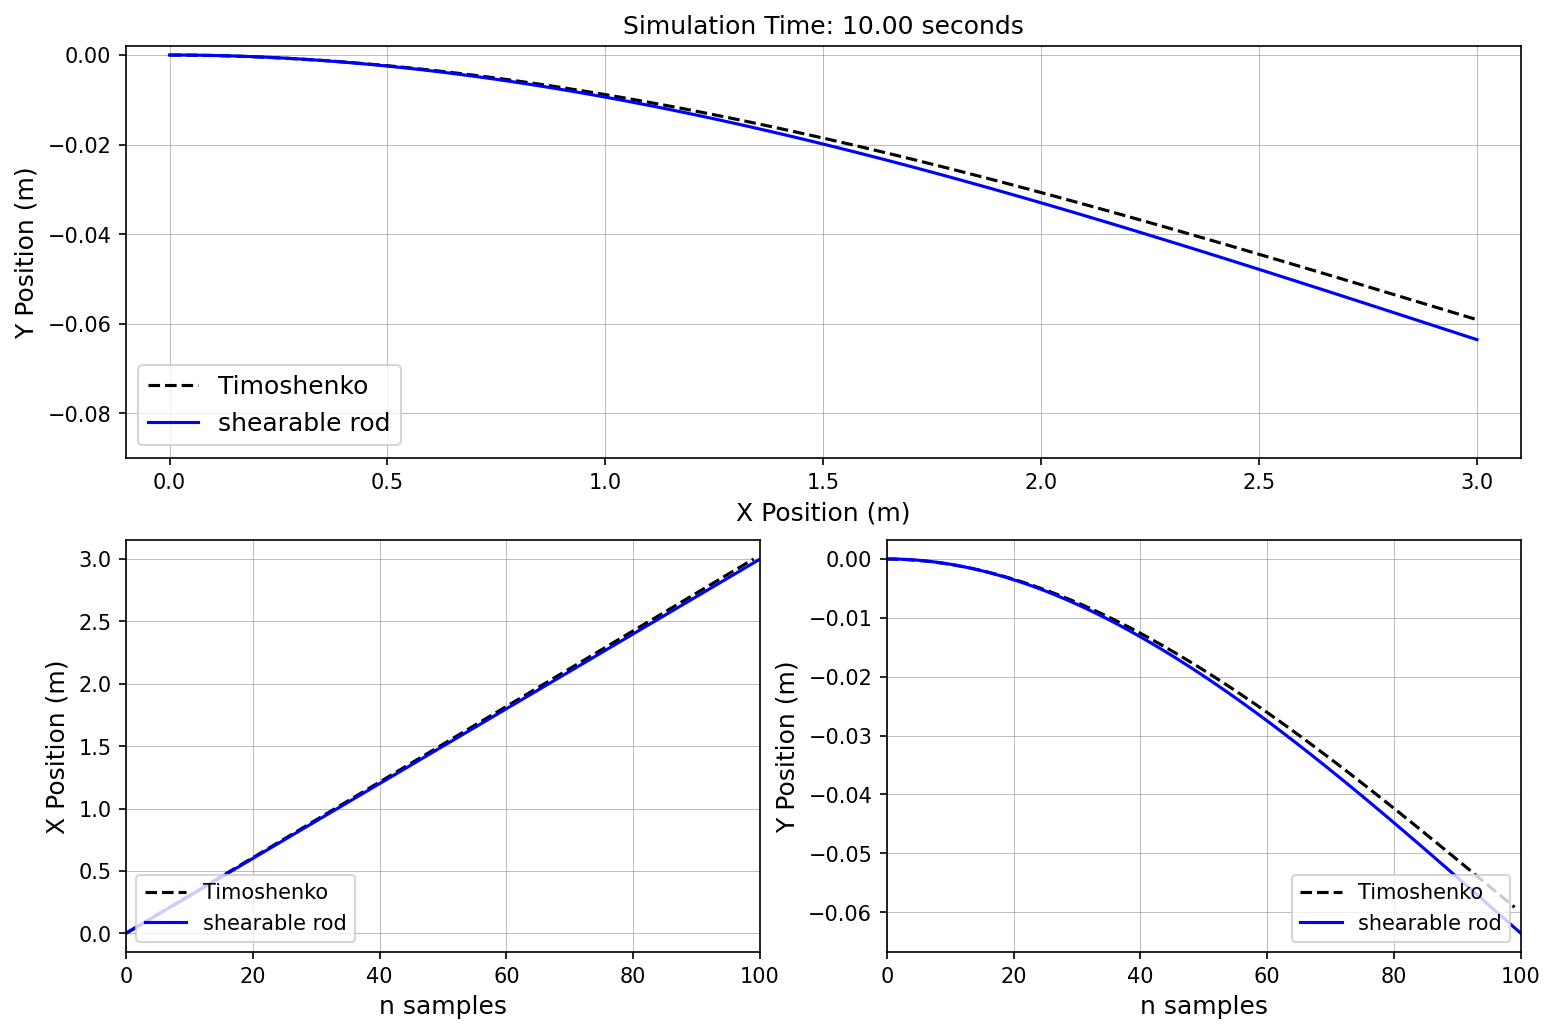

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.gridspec as gridspec


evolve_for_time = 10.0
update_interval = 1.0e-1

# update the plot every 1 second
fig = plt.figure(figsize=(12, 8), frameon=True, dpi=150)
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])


first_interval_time = update_interval + time
last_interval_time = time + evolve_for_time
for stop_time in np.arange(
    first_interval_time, last_interval_time + dt, update_interval
):
    time = run_and_update_plot(dynamic_update_sim, dt, time, stop_time, ax, ax2, ax3)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()